In [997]:
# libraries 
import numpy as np
from numpy.random import normal

import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools

import scipy
from scipy.integrate import simps as simps


from fun import *

# Model 


$$
dR(t) =  \theta(t) \left( \mu - R(t)\right)dt + \sigma(t)  dW(t)
$$

In [1045]:
# parameters of model
theta_fun = lambda t : 1 + np.sin(t*np.pi*2)
sg_fun = lambda t :  1+ (t-.5)**2
mu = 3

# distribution of starting point
def R0():
    return np.random.normal(0,1)

# number of generated curves
N = 250


# discretisation of unit interval
grid_size = 500
T = np.linspace(0,1,grid_size)

# EulerMaruyama approximation step, for curves generation
dt = 1e-3

In [1]:
# plot
fig,[axl,axr] = plt.subplots(figsize = (16,4),ncols=2,sharey=True)
fig.suptitle('model hyperparameters', fontsize = 25, y =1.1)
axl.plot(T,theta_fun(T), lw=4, alpha=.8); axl.set_title('speed of reversion : $\\theta(t)$', fontsize = 20)
axr.plot(T, sg_fun(T), lw=4, alpha=.8); axr.set_title('instant volatitly : $\sigma(t)$',fontsize = 20)

axr.set_xlabel('Time')
axl.set_xlabel('Time')
plt.show()


fig,[axl,axr] = plt.subplots(figsize = (16,4),ncols=2)
axl.scatter(0, mu,  s=50); axl.axhline(mu, alpha=.5); 
axl.set_title('long term mean level : $\mu$', fontsize = 20)
axl.axes.get_xaxis().set_visible(False); axl.set_yticks([3]); axl.set_yticklabels([3], fontsize = 18)
for _ in ['top', 'right', 'bottom', 'left']:
    axl.spines[_].set_visible(False); 

data = np.random.randn(1000)

# Create a KDE plot using Seaborn
sns.histplot(pd.DataFrame([R0() for _ in range(1000)], columns = ['location']),
             y='location', kde=True,stat = 'probability', ax= axr)
axr.set_title('starting position : $R(0)$',fontsize = 20)
for _ in ['top', 'right']:
    axr.spines[_].set_visible(False); 
    
plt.show()







NameError: name 'plt' is not defined

# Generate curves

In [1051]:
# for plotting
alpha = 10/N

In [1052]:
# generate curves
Rs = np.array([ EulerMaruyama_approx_sol(dt,T, mu, theta_fun ,sg_fun, R0) for i in range(N)])

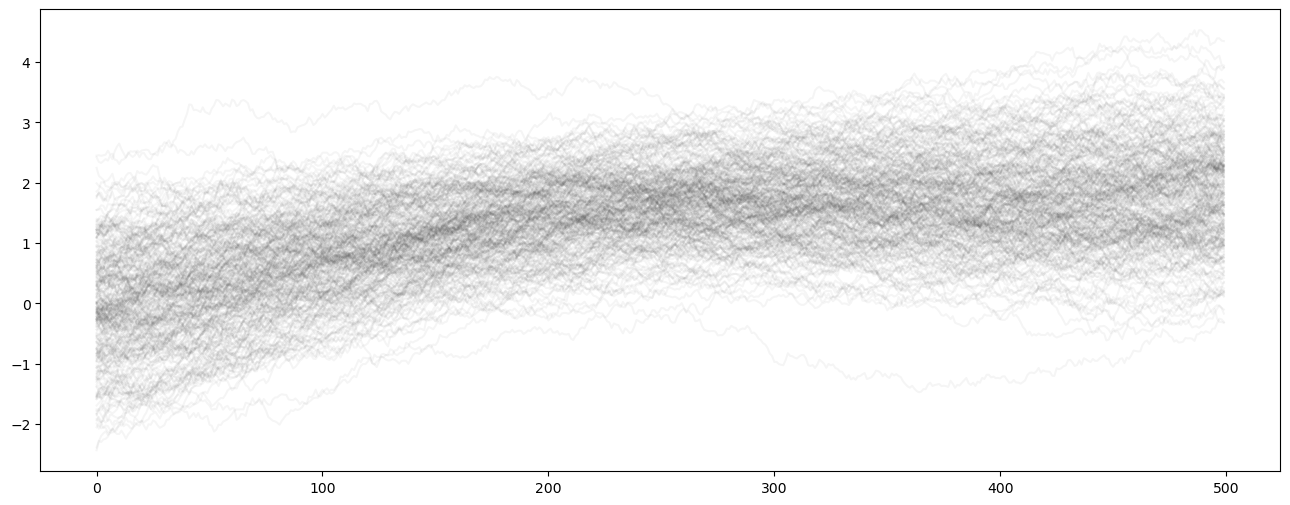

In [1053]:
fig,ax = plt.subplots(figsize = (16,6))
ax.plot(Rs.T, alpha=alpha, color='k'); plt.show()

# Estimation

## QV

In [1054]:
# compute QV process of each curve
emp_QVs = np.array([QV(R) for R in Rs])

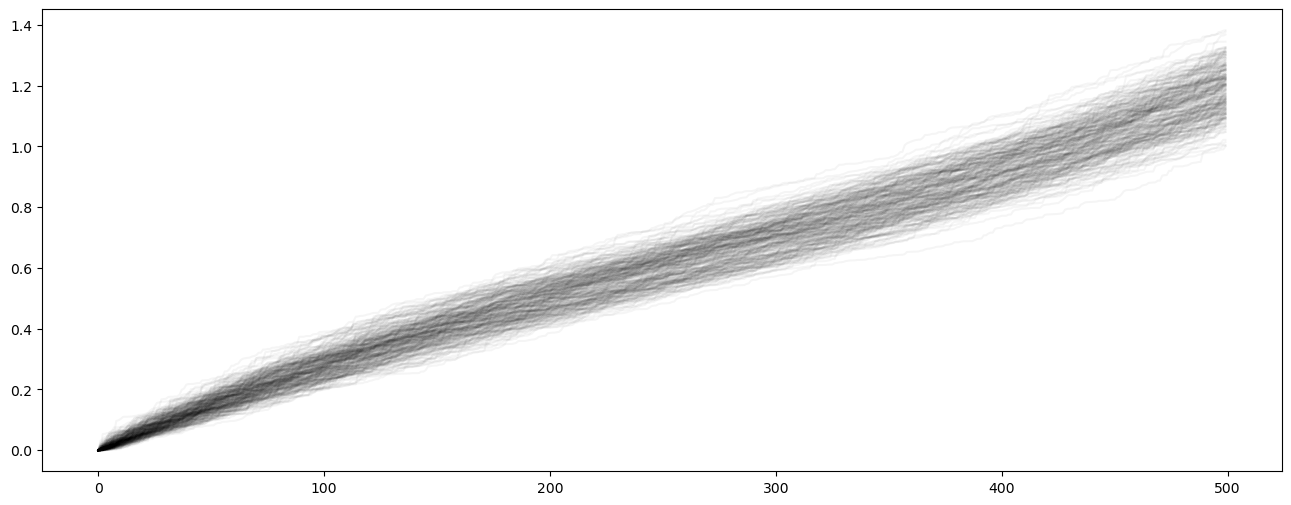

In [1055]:
fig,ax = plt.subplots(figsize = (16,6))
ax.plot(emp_QVs.T, alpha=alpha, color='k'); plt.show()

## Sigma

In [1056]:
# 1st approach: AVERAGE, SMOOTH
# average to get an estimate of the QV process
mean_emp_QV = emp_QVs.mean(0)

# bandwith parameter
h = .15*grid_size**(-1/5)

# local linear smooth of empirical QV to estimate derivative
_ =  np.array([LLS(T,mean_emp_QV,K,h)(t) for t in T])
LLS_mean_emp_QV = _[:,0]; LLS_Der_mean_emp_QV = _[:,1]


# 2nd approach: TAKE NUMERICAL DERIVATIVE, AVERAGE, SMOOTH
# compute the numerical derivative of the empirical QV of each sample curve, and average them
NumDer_emp_QVs = (np.diff(QVs)*grid_size).mean(0)
# smooth the resulting average derivative
LLS_empirical_der_meanQVs = np.array([ LLS(T[:-1],NumDer_emp_QVs,K,h)(t) for t in T])[:,0]

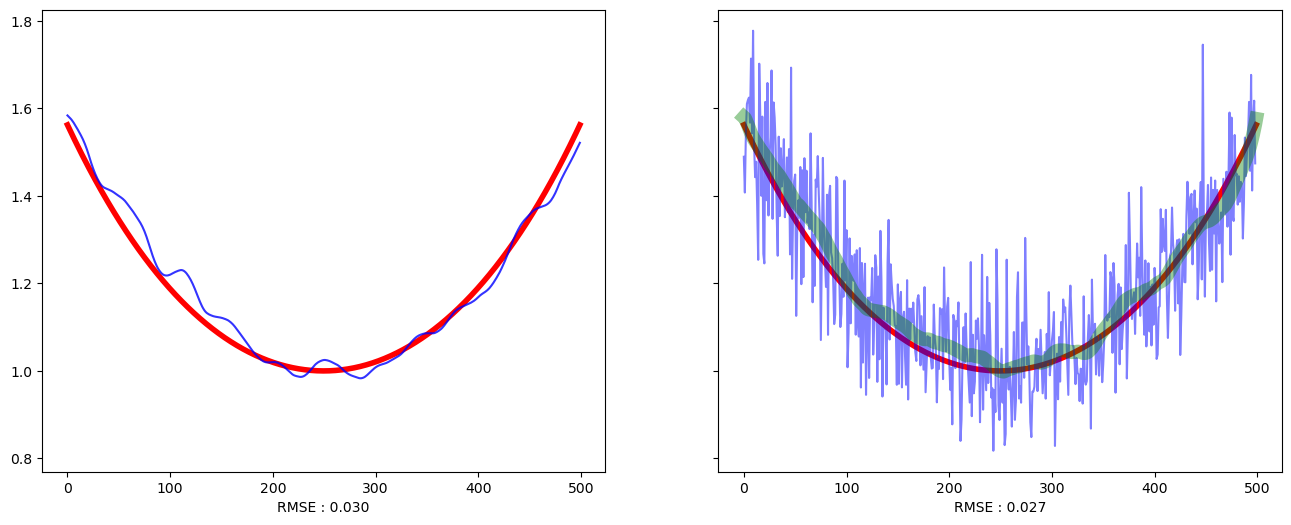

In [1057]:
fig,[axl,axr] = plt.subplots(figsize = (16,6),ncols=2,sharey=True)



axl.plot(sg_fun(T)**2, lw=4,c='r'); axr.plot(sg_fun(T)**2, lw=4,c='r')


axl.plot(LLS_Der_mean_emp_QV, alpha=.8, color='b'); 

axr.plot(NumDer_emp_QVs, alpha=.5, color='b');
axr.plot(LLS_empirical_der_meanQVs,alpha=.4, lw=10, color='green');

axl.set_xlabel('RMSE : {:.3f}'.format(RMSE(LLS_Der_mean_emp_QV, sg_fun(T)**2)))


axr.set_xlabel('RMSE : {:.3f}'.format(RMSE(LLS_empirical_der_meanQVs, sg_fun(T)**2)))
plt.show()

### every-curve-approach

In [ ]:
# # smoothing kernel
# K = lambda x : 3/4*(1-x**2) if  3/4*(1-x**2) > 0 else 0

# # badwith
# h = .3*grid_size**(-1/5)

# _ =  np.array([[ univariate_local_linear_smoothing(T,Y,K,h)(t) for t in T] for Y in tqdm(QVs)])

# LLS_QVs = _[:,:,0]
# LLS_derQVs = _[:,:,1]


# mean_LLS_derQVs = LLS_derQVs.mean(0)
# mean_empirical_derQVs = (np.diff(QVs)*grid_size).mean(0)

In [ ]:
# plot 
# fig,[axl,axr] = plt.subplots(figsize = (16,6),ncols=2,sharey=True)
# axl.plot(LLS_QVs.T, alpha=alpha, color='k'); axr.plot(QVs.T, alpha=alpha, color='k')
# axl.plot(LLS_QVs.mean(0), alpha=.8, color='b'); axr.plot(QVs.mean(0), alpha=.8, color='b'); plt.show()


# fig,[axl,axr] = plt.subplots(figsize = (16,6),ncols=2,sharey=True)
# axl.plot(LLS_derQVs.T, alpha=alpha, color='k'); axr.plot((np.diff(QVs)*grid_size).T, alpha=alpha, color='k');


# axl.plot(mean_LLS_derQVs, alpha=.8, color='b'); 
# axr.plot(mean_empirical_derQVs, alpha=.8, color='b');

# axl.plot(sg_fun(T)**2, lw=4,c='r'); axr.plot(sg_fun(T)**2, lw=4,c='r')
# axl.set_xlabel('RMSE : {:.3f}'.format(RMSE(mean_LLS_derQVs, sg_fun(T)**2)))
# axr.set_xlabel('RMSE : {:.3f}'.format(RMSE(mean_empirical_derQVs, sg_fun(T)[:-1]**2)))
# plt.show()


----

### Mean and Variance

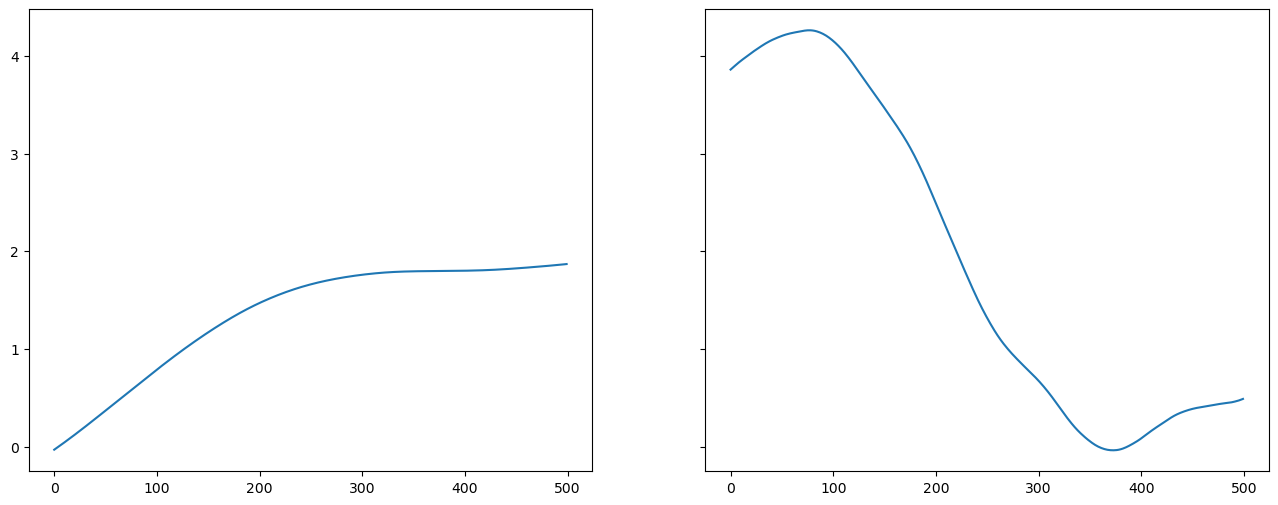

In [971]:
h = .5*grid_size**(-1/5)

_ = np.array([univariate_local_linear_smoothing(T,Rs.mean(0),K,h)(t) for t in T])
hat_mean = _[:,0]
hat_der_mean = _[:,1]

fig,[axl,axr] = plt.subplots(figsize = (16,6),ncols=2,sharey=True)
axl.plot(hat_mean); axr.plot(hat_der_mean)
plt.show()

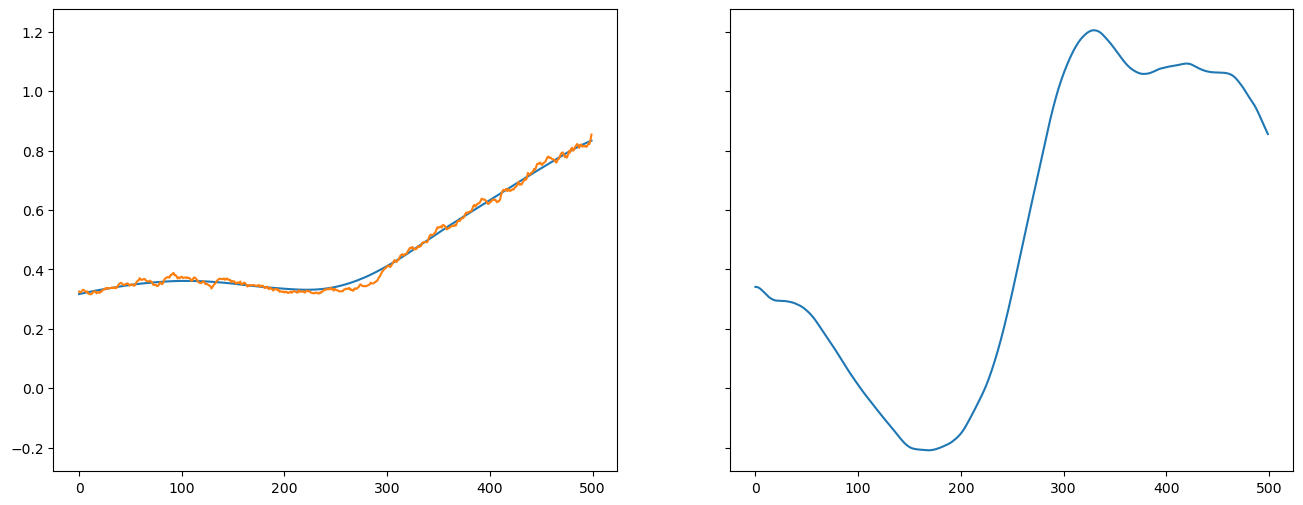

In [972]:
_ = np.array([univariate_local_linear_smoothing(T,(Rs**2).mean(0) - Rs.mean(0)**2,K,h)(t) for t in T])

hat_variance = _[:,0]
hat_der_variance = _[:,1] 

fig,[axl,axr] = plt.subplots(figsize = (16,6),ncols=2,sharey=True)
axl.plot(hat_variance); axr.plot(hat_der_variance)

axl.plot((Rs**2).mean(0) - Rs.mean(0)**2)
# axr.plot(np.diff((Rs**2).mean(0) - Rs.mean(0)**2)*grid_size)
plt.show()

----

### SDEs coeffs estimation

$$
\sigma^2(t) = \partial Q(t), \qquad t \in [0,1]
$$

In [973]:
hat_sigma = LLS_der_meanQVs**.5

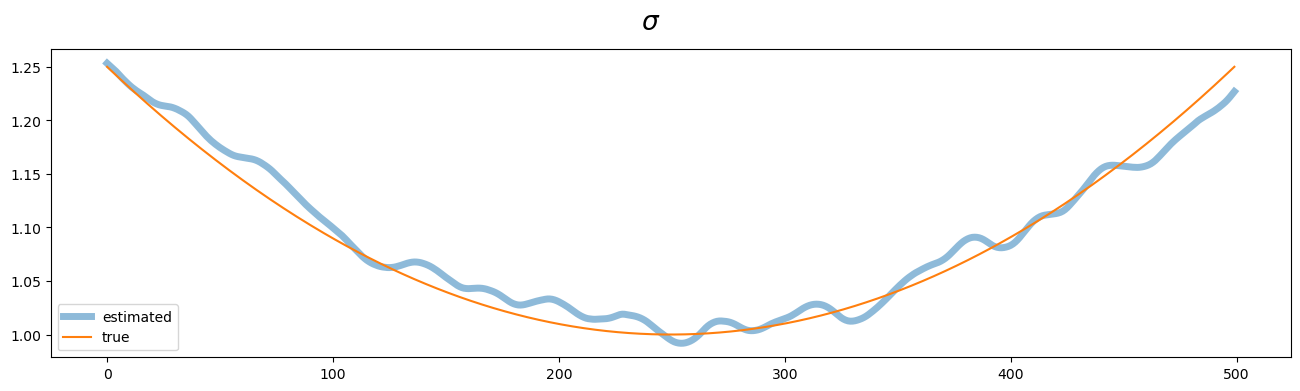

In [974]:
fig,ax=plt.subplots(figsize = (16,4))
ax.plot(hat_sigma, lw=5, alpha=.5, label='estimated')
ax.plot(sg_fun(T), label='true')
fig.suptitle('$\sigma$', fontsize= 19);ax.legend();plt.show()

----

$$\theta(t)  =  \frac{\sigma^2(t)  - \partial D(t)  }{2 D(t)} , 
\qquad t \in [0,1]$$

In [975]:
hat_theta = ((hat_sigma**2 - hat_der_variance)/(2*hat_variance))

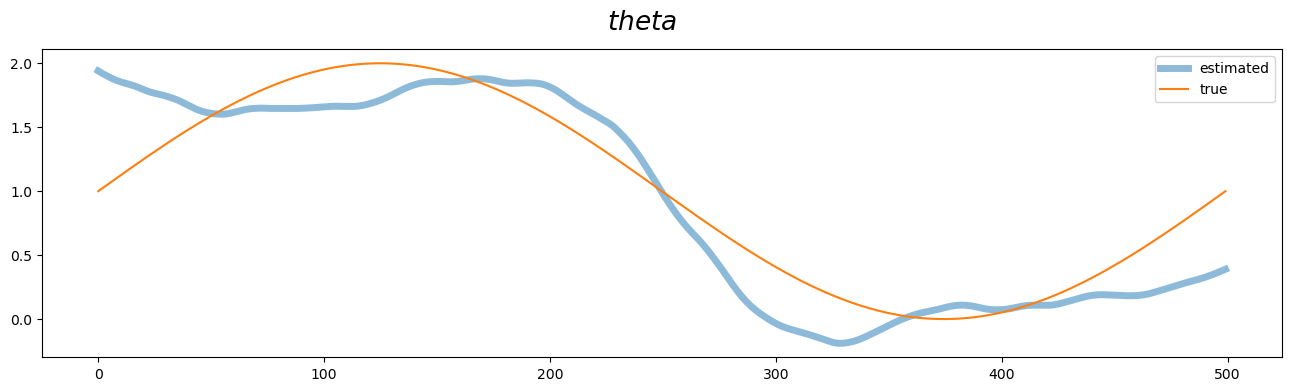

In [976]:
fig,ax=plt.subplots(figsize = (16,4))
ax.plot(hat_theta, lw=5, alpha=.5, label='estimated')
ax.plot(theta_fun(T), label='true')

# ax.set_ylim(-4,4)
fig.suptitle('$theta$', fontsize= 19);ax.legend();plt.show()



$$\mu =  \frac{ \partial m(t) +\theta(t) m(t)}{\theta(t) }, \qquad t \in [0,1]
$$

In [977]:
hat_mu = (hat_der_mean + hat_theta*hat_mean)/hat_theta

In [978]:
import seaborn as sns

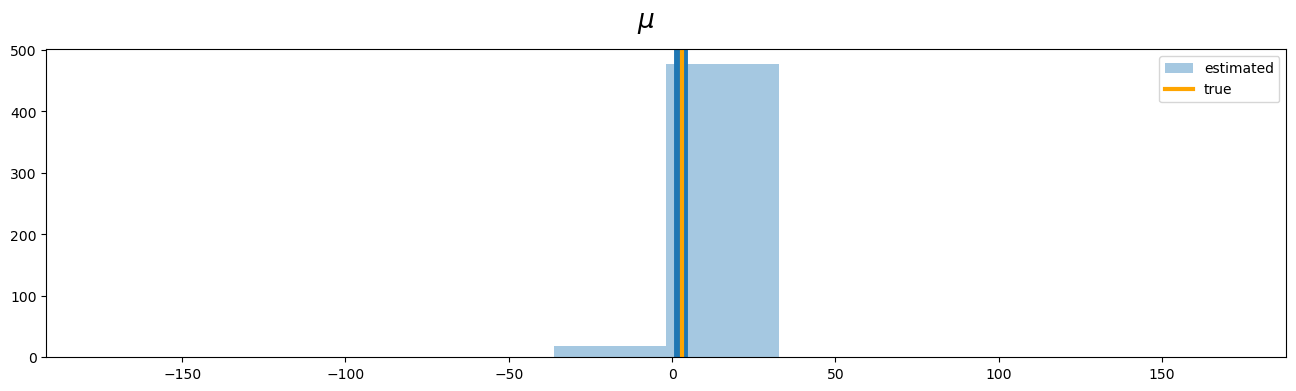

In [979]:
fig,ax=plt.subplots(figsize = (16,4))


ax.axvline(hat_mu.mean(0), lw=10)

ax.hist(hat_mu, alpha=.4,label = 'estimated')
ax.axvline(mu, label='true', lw=3, color='orange')
# ax.set_xlim(0,6)
fig.suptitle('$\mu$', fontsize= 19);ax.legend();plt.show()

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

----

## samples from closed form solution

The funcitonal Vasicek model admits the following closed form solution:
$$
   R(t) =   \exp\left\{-\int_0^t \theta(u) du\right\} R(0) +\mu \int_0^t  \exp\left\{-\int_s^t \theta(u) du\right\} \theta(s)   ds + \int_0^t  \exp\left\{-\int_s^t \theta(u) du\right\} \sigma(s)  dW(s), \quad t \in [0,\infty).
$$
    

In [4]:
t = sympy.symbols('t')

theta_sympy = sympy.lambdify(t, theta_fun(t))

integra_theta_sympy = sympy.integrate(theta_sympy(t), t)

integral_theta_fun = sympy.lambdify(t, integra_theta_sympy)



In [5]:
for t_ix,t in enumerate(T):
    
    
    if t>0:
        deterministic_R_fun = np.exp(integral_theta_fun(t))*R0 \
          + mu*simps(
            -np.array([integral_theta_fun(t)-integral_theta_fun(s) for s in T[:t_ix]])*sg_fun(T[:t_ix])
                      , T[:t_ix])
        
        

In [39]:
# def generate_Vasicek_trajectory_FromClosedForm(R0,theta_fun,sg_fun,mu, T):
    
#     t = sympy.symbols('t')

#     theta_sympy = sympy.lambdify(t, theta_fun(t))

#     integra_theta_sympy = sympy.integrate(theta_sympy(t), t)

#     integral_theta_fun = sympy.lambdify(t, integra_theta_sympy)
    
    
#     for t_ix,t in enumerate(T):
#         deterministic_R_fun = np.exp(integral_theta_fun(t))*R0 \
#               + mu*simps(
#                 -np.array([integral_theta_fun(t)-integral_theta_fun(s) for s in T[:t_ix]])*sigma_fun(T[:t_ix])
#                           , T[:t_ix])
    
    
    

NameError: name 'runs' is not defined